データの取り扱い
-----------------

PyTorchではデータを取り扱う際に、基本的な要素が2つ存在します。

``torch.utils.data.Dataset``と``torch.utils.data.DataLoader``です。

<br>

``Dataset`` は各ラベルと、それに対応するサンプルデータを保持します。

``DataLoader`` は``Dataset``をイテレーティブに（＝反復処理可能に）操作できるようラップしたものになります。

<br>

（詳細）
https://pytorch.org/docs/stable/data.html





In [1]:
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
# numpyをインポート


``torchvision.datasets`` モジュールには、画像データの ``Dataset`` オブジェクトがたくさん用意されています。

例えば、CIFAR, COCOなどです ([データセット一覧はこちらから](https://pytorch.org/docs/stable/torchvision/datasets.html))。

本チュートリアルでは、FashionMNISTデータセットを使用します。

In [3]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# テストデータをdatasetsからダウンロード
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.60MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 100kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.30MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.28MB/s]


In [4]:
len(test_data)

10000

In [5]:
batch_size = 256

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([256, 1, 28, 28])
Shape of y:  torch.Size([256]) torch.int64


モデルの構築
------------------

PyTorchでニューラルネットワークの形を定義する際には、[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)を継承します。


``__init__`` 関数で、ネットワークの各レイヤーを定義し、データの順伝搬を``forward`` 関数に定義します。

なお処理を高速化するために、可能であればニューラルネットワークをGPU上へ移動させます。



In [6]:
class ConvwithBatchNorm(nn.Module):
    """基本モデル用"""
    def __init__(self, input_channels, output_channels, ks):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, ks, 1)
        self.norm = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x    
class ClassificationCNN(nn.Module):
    def __init__(self, output_channel, input_channel = 1, channel_a = 4):
        super().__init__()
        self.c1 = ConvwithBatchNorm(input_channel,channel_a,3)
        channel_b = channel_a * 2
        self.c2 = ConvwithBatchNorm(channel_a,channel_b,3)
        channel_c = channel_b * 2
        self.c3 = ConvwithBatchNorm(channel_b,channel_c,3)
        self.co = ConvwithBatchNorm(channel_c,output_channel,3)


    def forward(self, x):
        # xの次元が３次元なら０次元位置に次元を追加
        if x.dim() == 3:
            x = torch.unsqueeze(x,0)
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.co(x)
        x = nn.AvgPool2d(x.size(2))(x)
        x = torch.squeeze(x)
        x = torch.nn.Softmax(0)(x)
        return x


In [7]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
model = ClassificationCNN(10).to(device)
train_loss = []; test_loss = []; total_epochs = 0
print(model)

Using cpu device
ClassificationCNN(
  (c1): ConvwithBatchNorm(
    (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (c2): ConvwithBatchNorm(
    (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (c3): ConvwithBatchNorm(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (co): ConvwithBatchNorm(
    (conv): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
)


モデルパラメータの最適化
----------------------------------------

ニューラルネットワークモデルを訓練するためには、

損失関数：[loss function](<https://pytorch.org/docs/stable/nn.html#loss-functions)と、最適化手法：[optimizer](https://pytorch.org/docs/stable/optim.html)が必要です。



In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#スケジューラーを入れる場合はここに記述
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor = 0.5, patience=5)

1回の訓練ループにおいてモデルは、まず訓練データのバッチに対して推論を実行して損失誤差を計算し、

その後、損失誤差をバックプロパゲーションして、モデルパラメータを更新します。

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    total_loss /= batch
    #print(f"loss: {total_loss:>7f} ")
    
    return total_loss

また、モデルがうまく学習していることを確認するために、テストデータセットに対するモデルの性能も確認します。

In [10]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= batch
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    return test_loss, correct

訓練プロセスでは複数イテレーションを実行します。

各エポックの間、モデルはより良い予測ができるようにパラメータを学習します。

エポックごとにモデルの正解率と損失を出力して、正解率が向上し、損失が低下していっているかを確認します。

In [11]:
epochs = 2
total_epochs += epochs
for t in range(epochs):
    print(f"-------------------------------\nEpoch {t+1}")
    train(train_dataloader, model, loss_fn, optimizer)
    print("test_for_train:", end ="")
    train_loss.append(test(train_dataloader, model))
    print("test_for_test:", end ="")
    test_loss.append(test(test_dataloader, model))
print("Done!")

-------------------------------
Epoch 1
test_for_train:Accuracy: 55.8%, Avg loss: 2.304362
test_for_test:Accuracy: 55.8%, Avg loss: 2.352069
-------------------------------
Epoch 2
test_for_train:Accuracy: 52.4%, Avg loss: 2.299154
test_for_test:Accuracy: 52.5%, Avg loss: 2.345959
Done!


学習曲線の描画
-------------

エポック数に対する訓練データ，テストデータに対する正解率をプロット

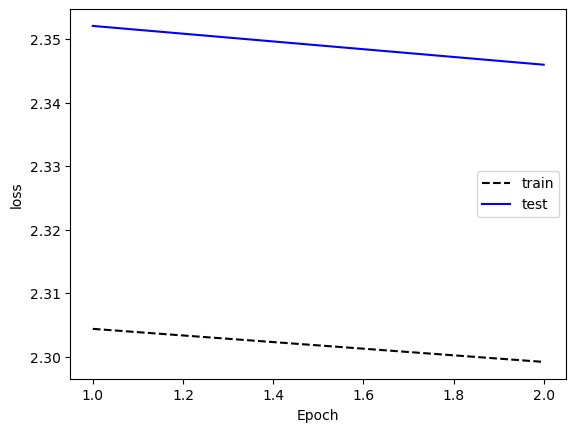

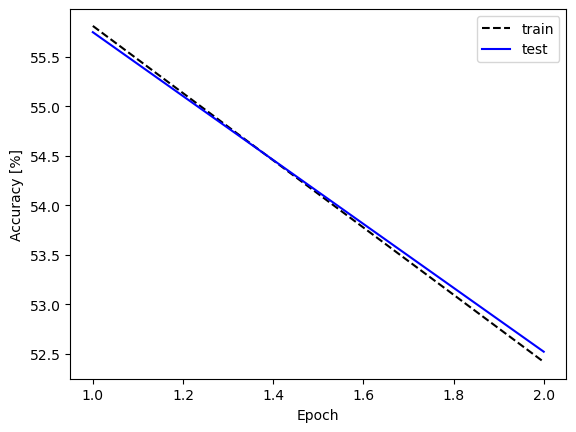

In [12]:
train_losses = torch.tensor(train_loss)
test_losses = torch.tensor(test_loss)
plt.plot(range(1,total_epochs+1), train_losses[:,0], label="train", color="black", linestyle="dashed")
plt.plot(range(1,total_epochs+1), test_losses[:,0], label="test", color="blue")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.plot(range(1,total_epochs+1), train_losses[:,1]*100, label="train", color="black", linestyle="dashed")
plt.plot(range(1,total_epochs+1), test_losses[:,1]*100, label="test", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.legend()
plt.show()


モデルの保存
-------------

モデルを保存する一般的な方法は、モデルの内部状態の辞書（モデルのパラメータを含む）をシリアル化する手法です。


In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")


Saved PyTorch Model State to model.pth


モデルの読み込み
----------------------------

モデルの読み込む際には、まずモデルの構造を再作成し、そのインスタンスに、保存しておいた状態辞書をロードします。


In [14]:
model = NeuralNetwork()
model = ClassificationCNN(10)
model.load_state_dict(torch.load("model.pth"))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

これでモデルは推論可能な状態です。

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "T-shirt/top", Actual: "Ankle boot"


torch.Size([225, 1, 28, 28])
torch.Size([225, 10])


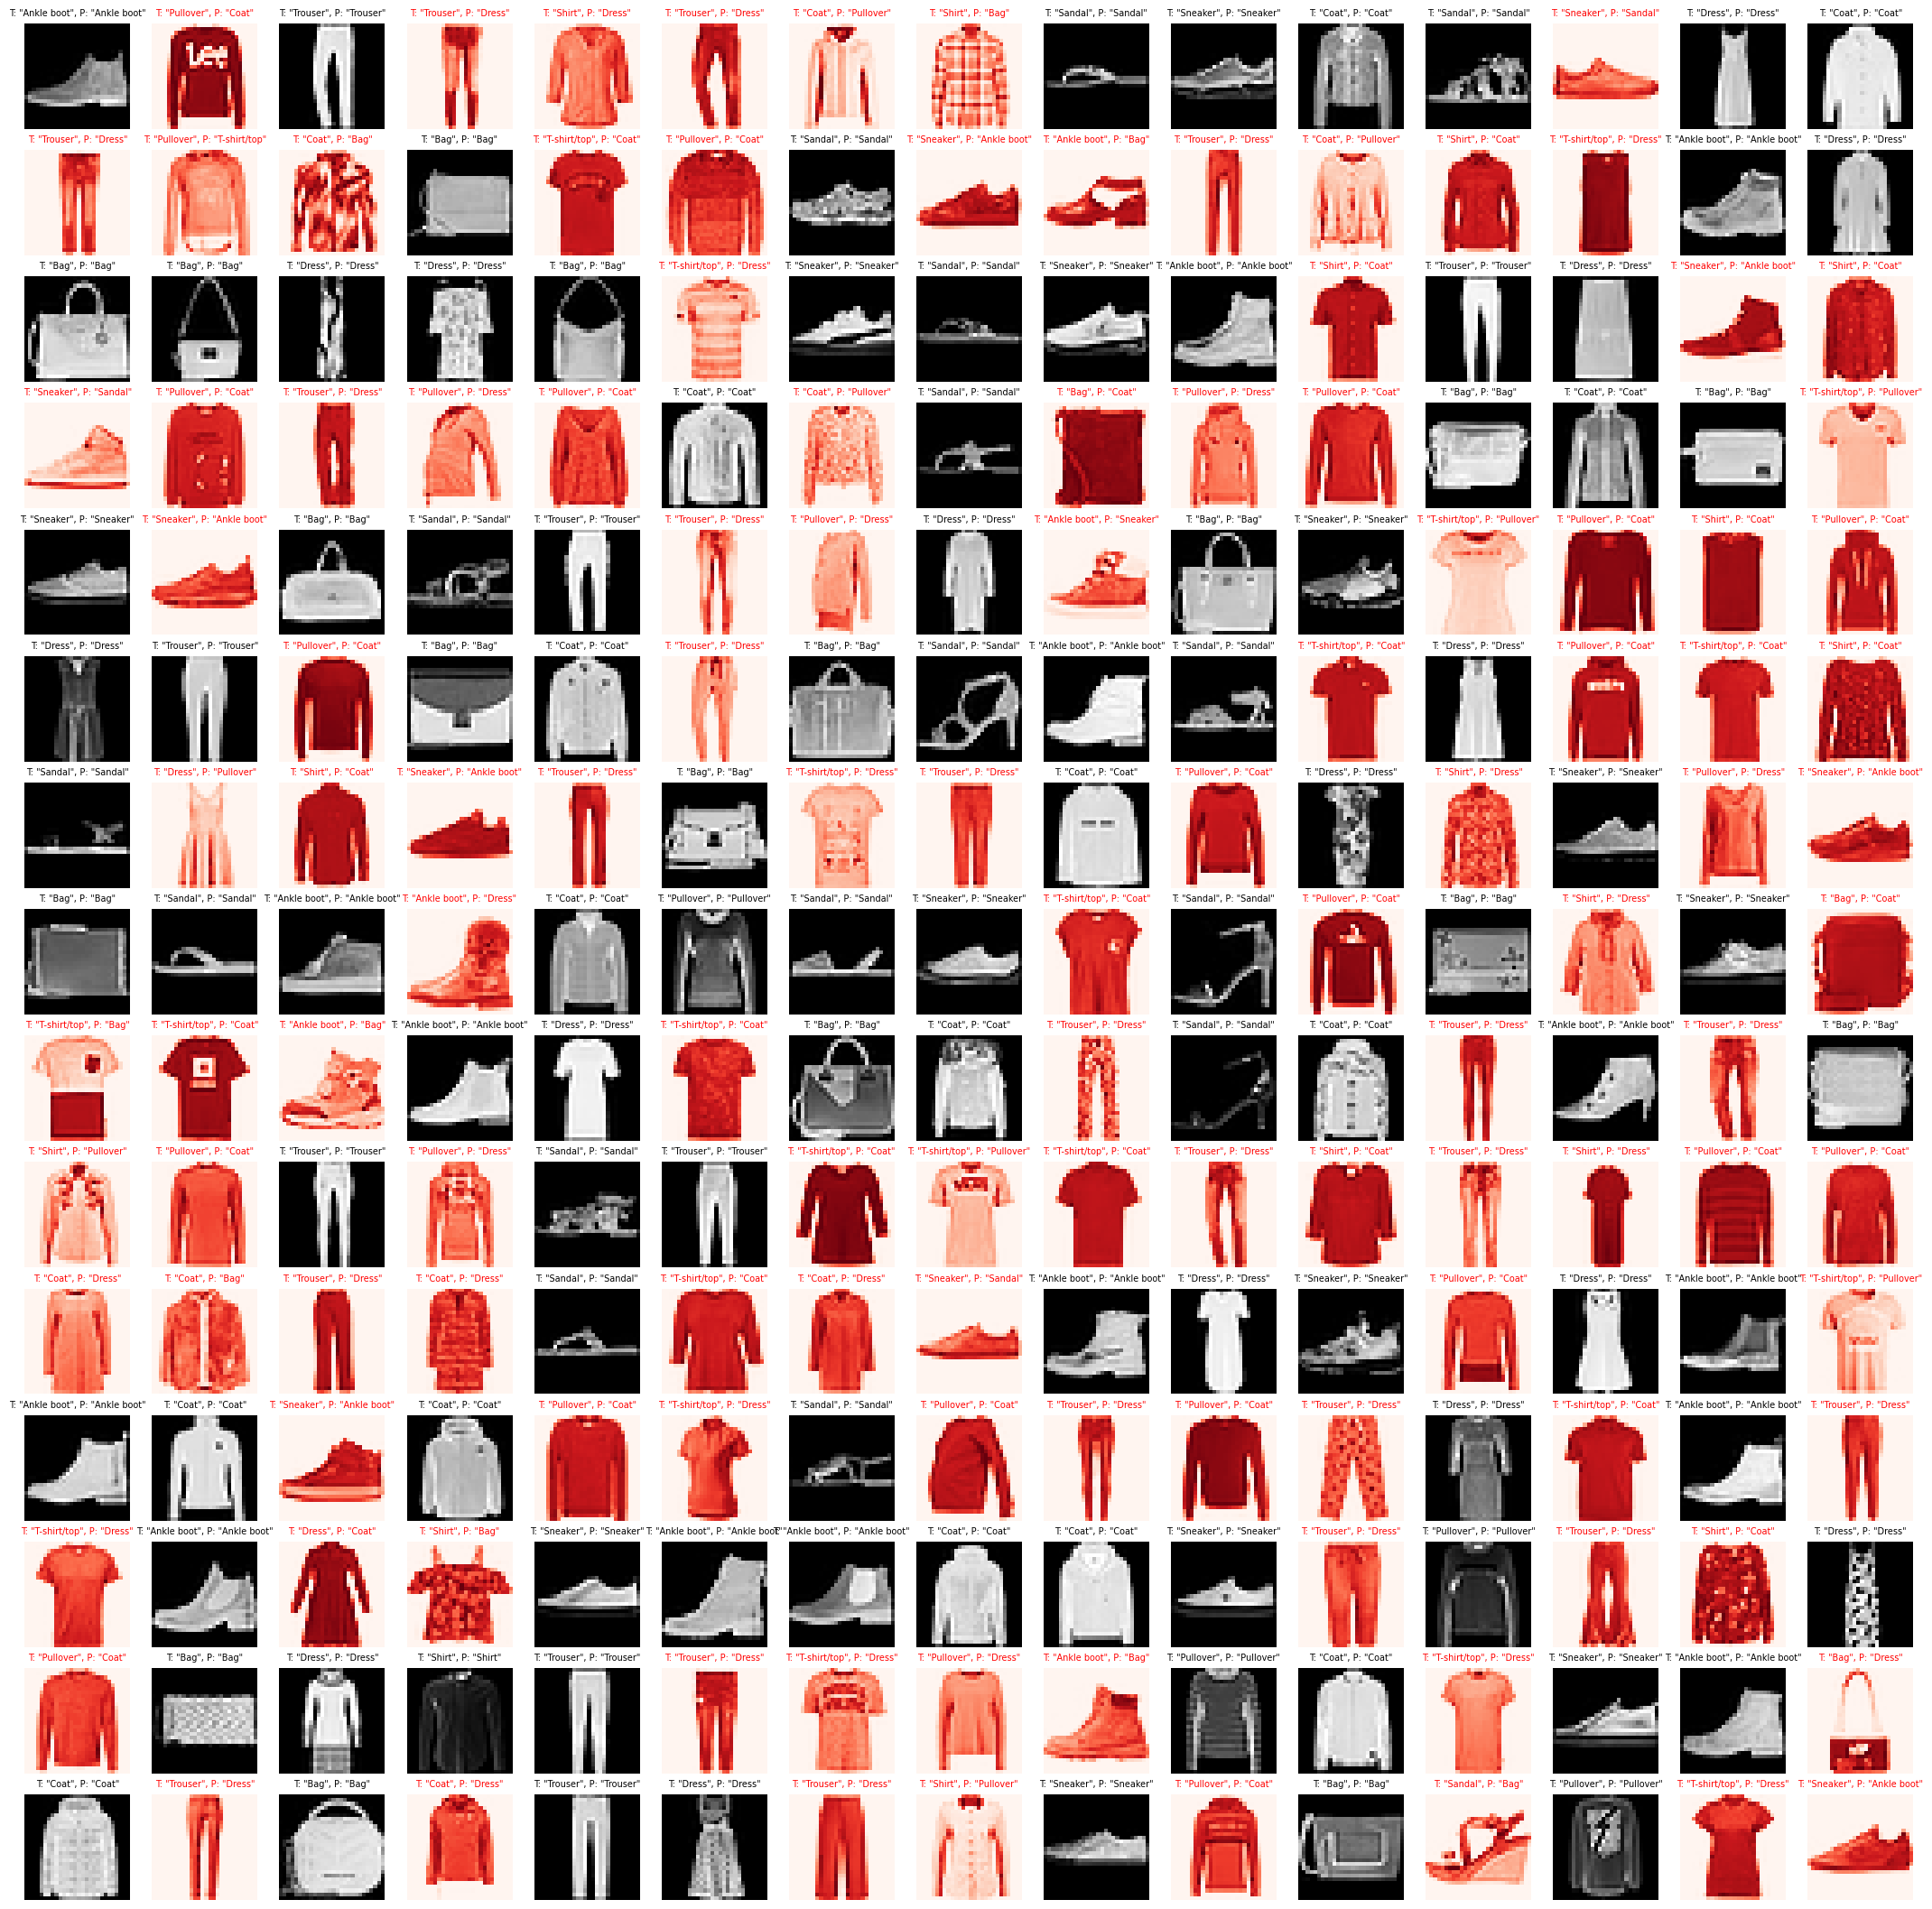

In [16]:

cols, rows = 15, 15

figure = plt.figure(figsize=(1.8 * cols, 1.8 * rows))
x = []; y = []

for i in range(rows):
    for j in range(cols):
        x.append(test_data[i*cols+j][0])
        y.append(test_data[i*cols+j][1])

x = torch.cat(x)
y = torch.tensor(y)
x = torch.unsqueeze(x,1)
print(x.shape)

with torch.no_grad():
    model.eval()
    pred = model(x)
    print(pred.shape)

for i in range(rows):
    for j in range(cols):
        predicted, actual = classes[pred[i*cols+j].argmax(0)], classes[y[i*cols+j]]
        
        figure.add_subplot(rows, cols, i*cols+j+1)
        
        plt.axis("off")
        if actual == predicted:
            # 正解の場合白黒で表示
            plt.title(f'T: "{actual}", P: "{predicted}"', fontsize=7)
            plt.imshow(x[[i*cols+j]].squeeze(), cmap="gray")
        else:
            # 不正解の場合赤く表示
            plt.title(f'T: "{actual}", P: "{predicted}"', fontsize=7, color="red")
            plt.imshow(x[[i*cols+j]].squeeze(), cmap="Reds")

In [17]:
type(test_data)

torchvision.datasets.mnist.FashionMNIST

In [18]:
test(test_dataloader, model)

Accuracy: 52.5%, Avg loss: 2.345959


(2.3459588992290006, 0.5252)